In [6]:
# Cell 1: Import libraries and define path for a SINGLE dataset file
import pickle
import os
import pprint
import numpy as np # Import numpy for shape checking

# --- Configuration ---
# !! IMPORTANT: Set this to the correct path of your SINGLE augmented .pkl file !!
# Example: 'libero_spatial_pos_neg_globalstd_h10_padded.pkl' (adjust as needed)
# Example using the filtered+augmented data:
dataset_pkl_path = 'libero_spatial_filtered_L100_std1.0_mind5_augmented_h10.pkl'
# -------------------

print(f"Attempting to load augmented data from: {dataset_pkl_path}")
augmented_data = None # Initialize to None
if os.path.exists(dataset_pkl_path):
    try:
        with open(dataset_pkl_path, 'rb') as f:
            augmented_data = pickle.load(f)
        print("Augmented data loaded successfully.")
    except Exception as e:
        print(f"Error loading augmented data: {e}")
else:
    print("Augmented data file not found.")

# --- Print Summary ---
if augmented_data:
    instructions = list(augmented_data.keys())
    num_instructions = len(instructions)
    num_samples = sum(len(v.get('samples', [])) for v in augmented_data.values())
    print("\n--- Augmented Data Summary ---")
    print(f"Number of instructions: {num_instructions}")
    print(f"Total number of samples: {num_samples}")
    if num_instructions > 0:
        first_instruction = instructions[0]
        print(f"First instruction key example: '{first_instruction}'")
        if first_instruction in augmented_data:
             num_samples_first_instr = len(augmented_data[first_instruction].get('samples', []))
             print(f"Number of samples for first instruction: {num_samples_first_instr}")


# --- Inspect Structure of First Sample ---
print("\n--- Inspecting First Sample from First Instruction (if available) ---")
if augmented_data and num_instructions > 0:
    first_instruction_key = list(augmented_data.keys())[0] # Use the actual first key
    if first_instruction_key in augmented_data:
        first_instruction_data = augmented_data[first_instruction_key]
        if first_instruction_data and first_instruction_data.get('samples'):
            first_sample = first_instruction_data['samples'][0] # Take the very first sample
            print(f"\nData for instruction: '{first_instruction_key}'")
            print("Structure of the first sample:")
            # Pretty print the keys and types/shapes of the values
            for key, value in first_sample.items():
                if isinstance(value, np.ndarray):
                    print(f"  '{key}': numpy array with shape {value.shape} and dtype {value.dtype}")
                else:
                     print(f"  '{key}': type {type(value)}")

            # Optionally, print the actual data for the first sample (can be large)
            # print("\nFull data for the first sample:")
            # pprint.pprint(first_sample)

            # Print positive history of the first sample
            print("\nPositive Action History (first sample):")
            pprint.pprint(first_sample.get('pos_action_hist'))
            # Print negative history of the first sample
            print("\nNegative Action History (first sample):")
            pprint.pprint(first_sample.get('neg_action_hist'))
        else:
            print(f"Instruction '{first_instruction_key}' has no samples.")
    else:
        print("First instruction key not found in data.")
else:
    print("Augmented data not loaded or is empty.")


# --- Save Test Dataset with ONE Sample per Instruction ---
print("\n--- Saving Test Dataset with ONE Sample per Instruction ---")
if augmented_data and num_instructions > 0:
    test_dataset = {}
    kept_instructions = 0
    total_samples_in_test = 0

    # Iterate through all instructions in the loaded data
    for instruction_key, instruction_data in augmented_data.items():
        # Check if the instruction has samples
        if instruction_data and instruction_data.get('samples'):
            # Take only the first sample
            first_sample = instruction_data['samples'][-5]
            # Create the entry for the test dataset
            test_dataset[instruction_key] = {'samples': [first_sample]}
            kept_instructions += 1
            total_samples_in_test += 1
        # else: # Optionally notify if an instruction had no samples
            # print(f"Instruction '{instruction_key}' has no samples, skipping for test set.")

    if test_dataset:
        test_filepath = "test_one_sample_per_instruction.pkl"
        with open(test_filepath, 'wb') as f:
            pickle.dump(test_dataset, f)

        print(f"Test dataset saved to: {test_filepath}")
        print(f"Contains {kept_instructions} instructions.")
        print(f"Contains {total_samples_in_test} total samples (one per instruction).")
    else:
         print("Could not save test dataset - no instructions with samples found.")

else:
    print("Could not save test dataset - no data available or loaded.")


Attempting to load augmented data from: libero_spatial_filtered_L100_std1.0_mind5_augmented_h10.pkl
Augmented data loaded successfully.

--- Augmented Data Summary ---
Number of instructions: 10
Total number of samples: 52775
First instruction key example: 'pick up the black bowl on the cookie box and place it on the plate demo'
Number of samples for first instruction: 4408

--- Inspecting First Sample from First Instruction (if available) ---

Data for instruction: 'pick up the black bowl on the cookie box and place it on the plate demo'
Structure of the first sample:
  'image': numpy array with shape (128, 128, 3) and dtype uint8
  'pos_action_hist': numpy array with shape (10, 7) and dtype float64
  'neg_action_hist': numpy array with shape (10, 7) and dtype float64

Positive Action History (first sample):
array([[-5.        , -5.        , -5.        , -5.        , -5.        ,
        -5.        , -5.        ],
       [-5.        , -5.        , -5.        , -5.        , -5.        

--- Starting Trajectory Plotting ---

Processing folder: libero_spatial


Tasks in libero_spatial:   0%|          | 0/10 [00:00<?, ?it/s]

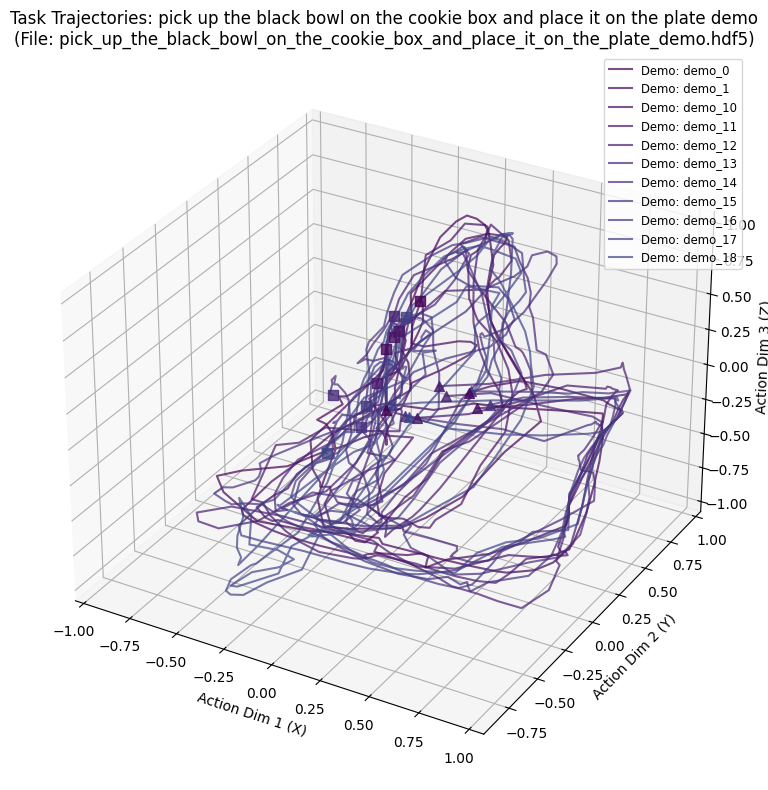

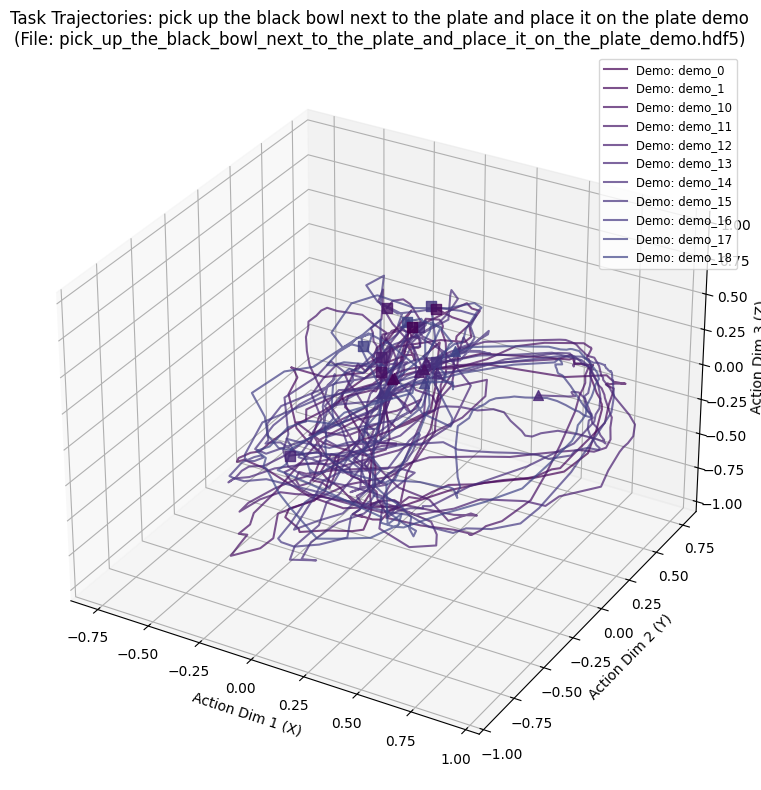

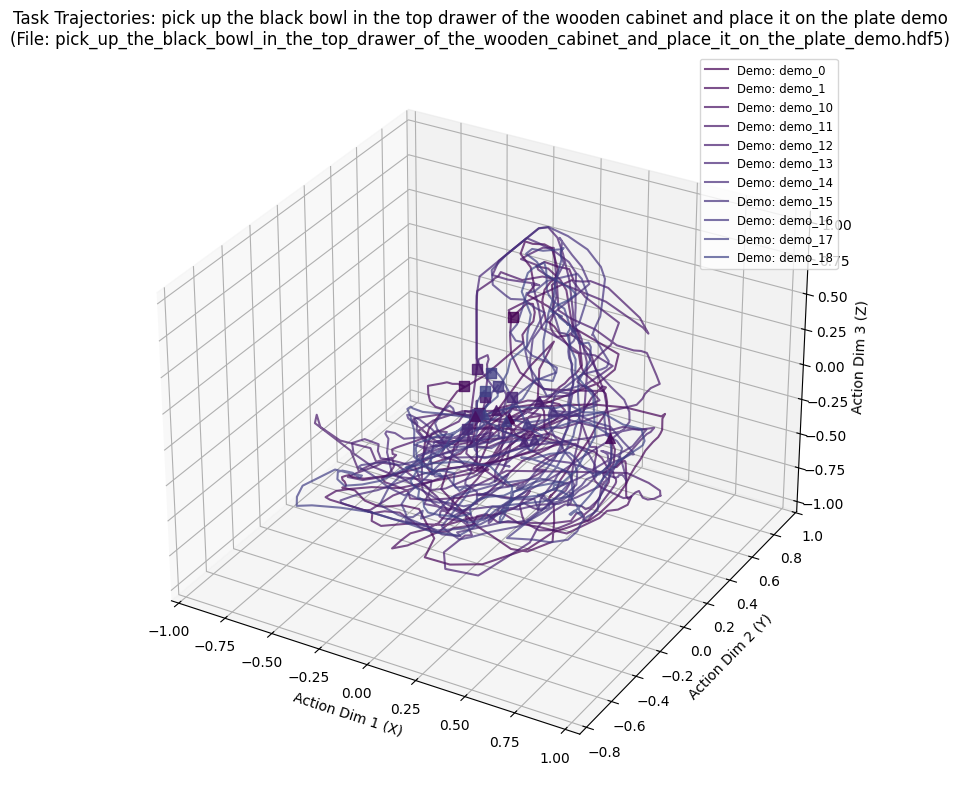

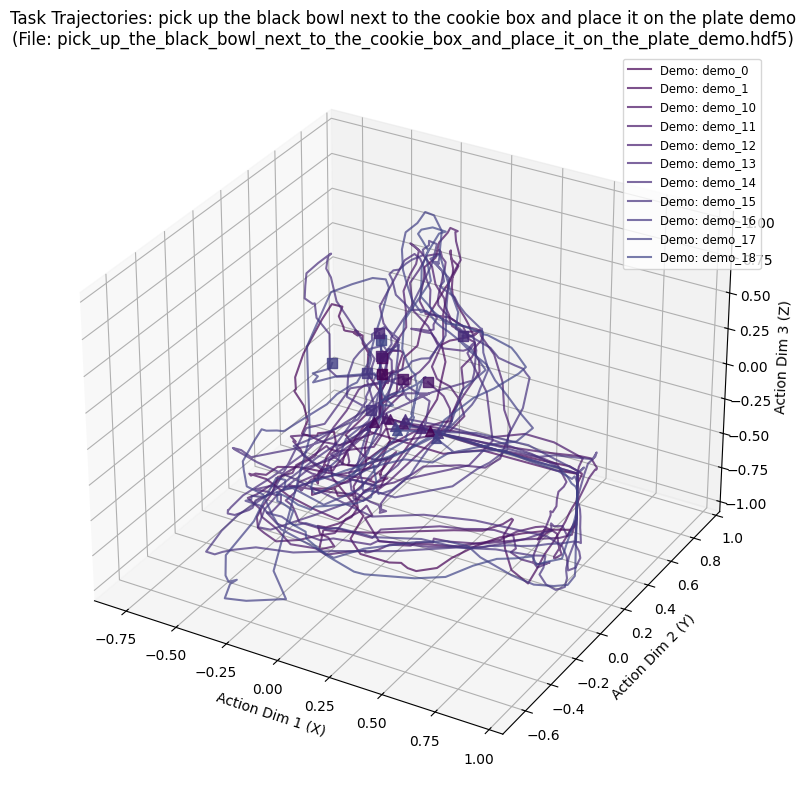

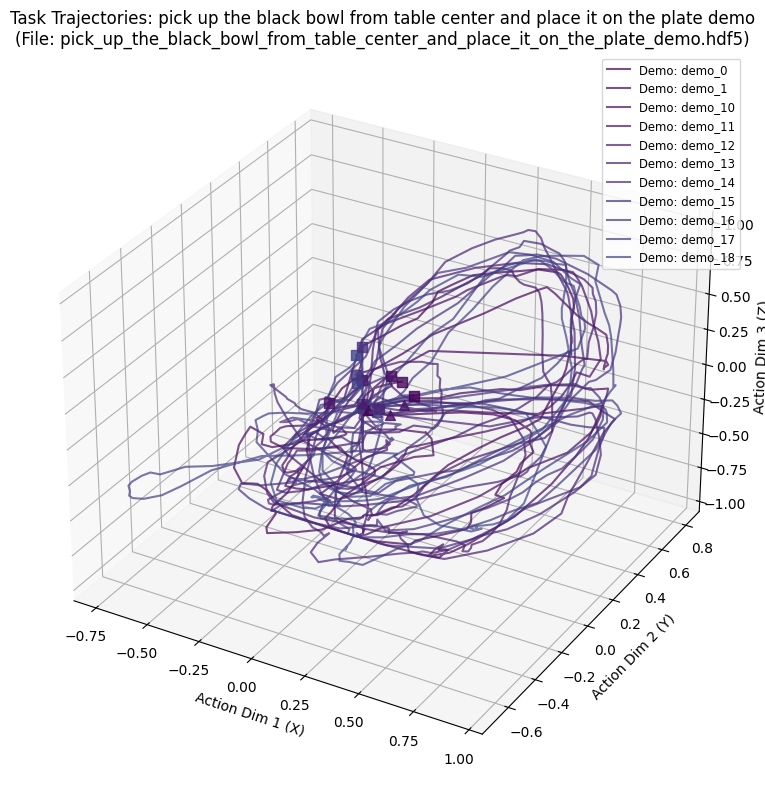

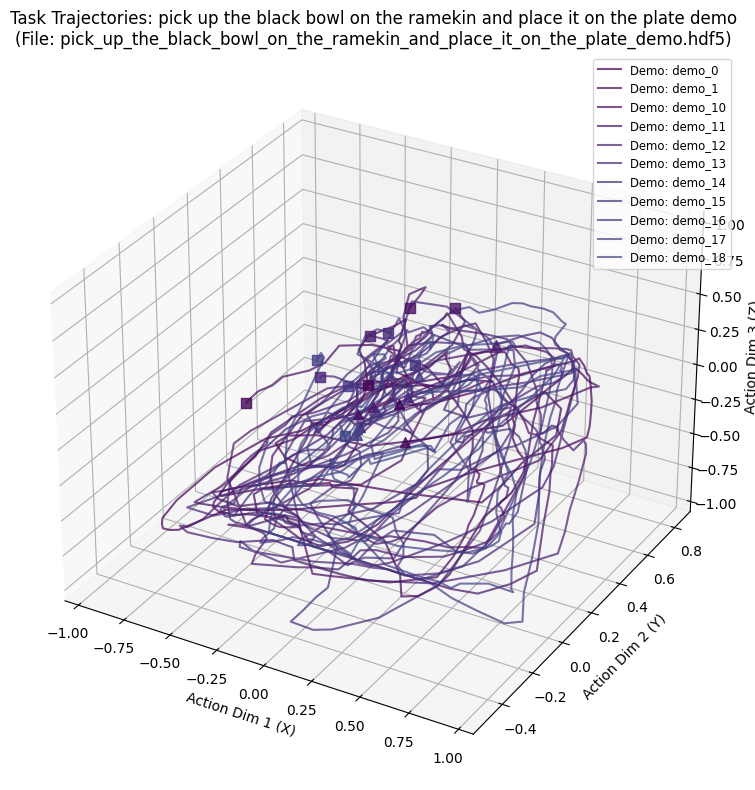

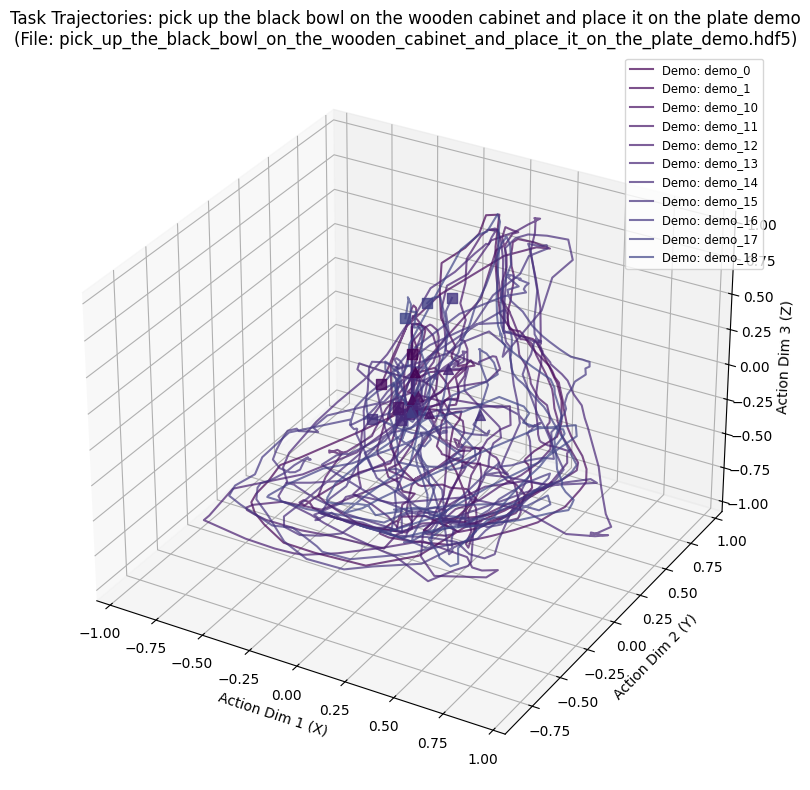

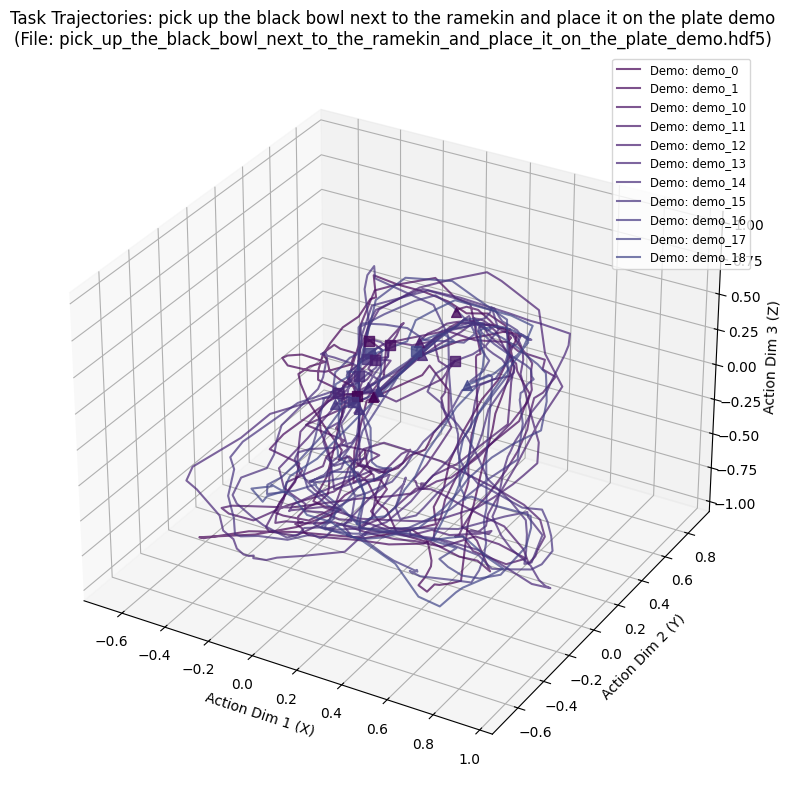

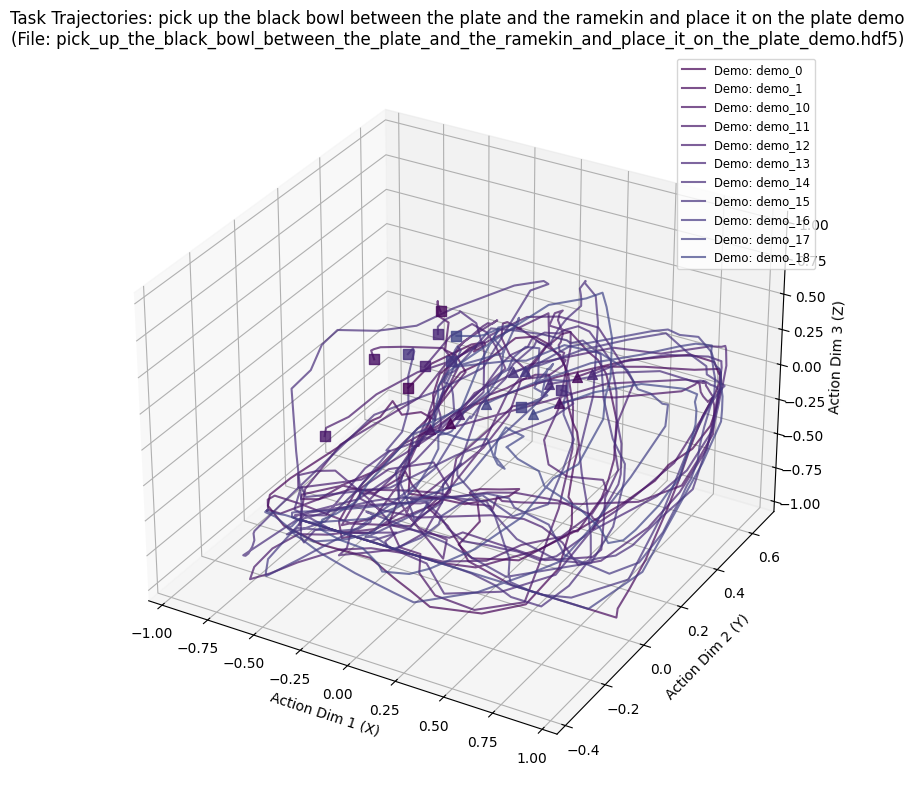

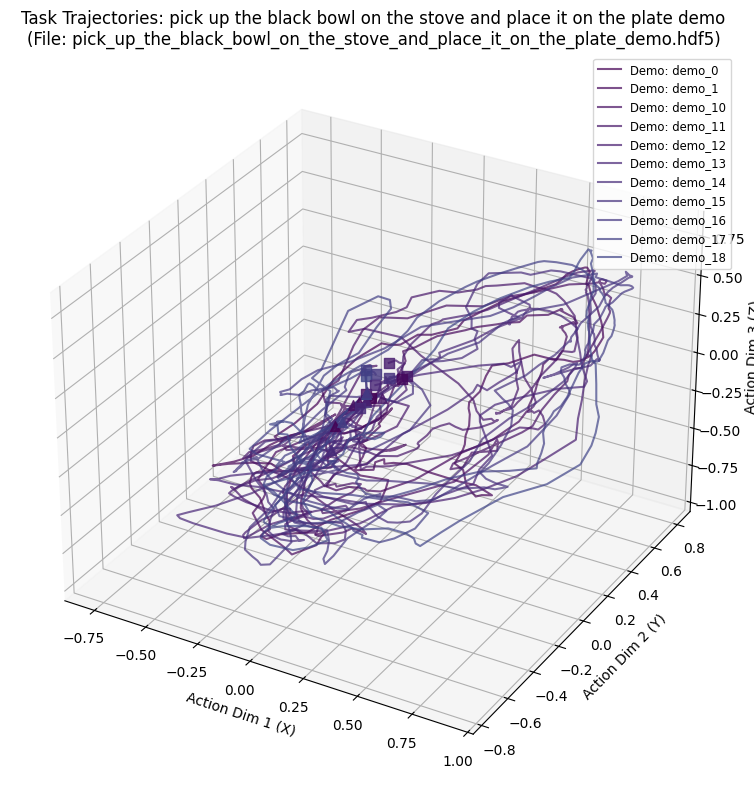


--- Trajectory Plotting Complete ---


In [3]:
# %% [markdown]
# # Plot Original Dataset Trajectories
#
# This notebook loads the original HDF5 datasets used for generating the augmented CLIP verifier dataset. It iterates through each task (instruction) and demonstration, plotting the trajectory based on the first 3 dimensions of the action sequence.

# %%
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Required for 3D plotting
from tqdm.notebook import tqdm # Use notebook-friendly tqdm
import re # For cleaning instruction strings
# Display plots inline in the notebook
%matplotlib inline
# %% [markdown]
# ## Configuration
# Set the base path to your datasets and the specific folders you want to process.

# %%
# --- Configuration ---
DATASET_BASE_PATH = '/home/xilun/LIBERO/libero/datasets' # Adjust if your path is different
DATASET_FOLDERS = ['libero_spatial'] # Add more folders if needed
# ---------------------

# Action dimension check (ensure actions have at least 3 dims)
MIN_ACTION_DIM_FOR_PLOT = 3

# %% [markdown]
# ## Helper Functions

# %% [markdown]
# ## Helper Functions

# %%
def clean_instruction_from_filename(filename):
    """Cleans the instruction string extracted from the HDF5 filename."""
    instruction = filename.replace('.hdf5', '').replace('_', ' ')
    # Remove potential numeric suffixes or uppercase parts often indicating variations
    instruction = ''.join(char for char in instruction if not char.isupper() and not char.isdigit())
    # Remove leading/trailing whitespace
    instruction = instruction.strip()
    return instruction

def plot_task_trajectories_3d(task_trajectories, instruction, task_filename):
    """
    Plots all demonstration trajectories for a single task on one 3D plot.
    Each trajectory gets a unique color.

    Args:
        task_trajectories (dict): A dictionary where keys are demo_keys and
                                  values are the corresponding action arrays (N, D).
        instruction (str): The natural language instruction for the task.
        task_filename (str): The original filename of the HDF5 file.
    """
    if not task_trajectories:
        print(f"No valid trajectories found for task: {instruction} ({task_filename})")
        return

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Get a colormap and generate unique colors for each demo
    num_demos = len(task_trajectories)
    colors = plt.cm.viridis(np.linspace(0, 1, num_demos)) # Or use plt.cm.tab10, etc.

    plot_occurred = False
    for i, (demo_key, actions) in enumerate(task_trajectories.items()):
        if i > 10:
            break
        if actions.shape[1] < MIN_ACTION_DIM_FOR_PLOT:
            print(f"Skipping plot for demo {demo_key} in {task_filename}: Action dimension ({actions.shape[1]}) < {MIN_ACTION_DIM_FOR_PLOT}")
            continue

        if actions.shape[0] == 0:
             print(f"Skipping plot for demo {demo_key} in {task_filename}: No actions in trajectory.")
             continue


        x = actions[:, 0]
        y = actions[:, 1]
        z = actions[:, 2]
        color = colors[i]

        # Plot the trajectory line
        ax.plot(x, y, z, color=color, linestyle='-', alpha=0.7, label=f'Demo: {demo_key}')
        # Mark start and end points (optional, can make plots busy)
        ax.scatter(x[0], y[0], z[0], color=color, s=50, marker='^', alpha=0.8) # Start
        ax.scatter(x[-1], y[-1], z[-1], color=color, s=50, marker='s', alpha=0.8) # End
        plot_occurred = True

    if not plot_occurred:
        print(f"No plottable trajectories (dim >= {MIN_ACTION_DIM_FOR_PLOT}) found for task: {instruction} ({task_filename})")
        plt.close(fig) # Close the empty figure
        return

    ax.set_xlabel('Action Dim 1 (X)')
    ax.set_ylabel('Action Dim 2 (Y)')
    ax.set_zlabel('Action Dim 3 (Z)')
    ax.set_title(f"Task Trajectories: {instruction}\n(File: {task_filename})")
    # Optionally add a legend if demo keys are important, otherwise remove legend call
    ax.legend(fontsize='small')
    plt.tight_layout()
    plt.show()
    plt.close(fig) # Close the figure after displaying

# %%
print("--- Starting Trajectory Plotting ---")

for folder in DATASET_FOLDERS:
    folder_path = os.path.join(DATASET_BASE_PATH, folder)
    if not os.path.exists(folder_path):
        print(f"Warning: Dataset folder {folder_path} does not exist. Skipping.")
        continue

    print(f"\nProcessing folder: {folder}")
    task_files = [f for f in os.listdir(folder_path) if f.endswith('.hdf5')]

    for task_filename in tqdm(task_files, desc=f"Tasks in {folder}"):
        instruction = clean_instruction_from_filename(task_filename)
        if not instruction:
             print(f"Warning: Could not extract valid instruction from {task_filename}. Skipping.")
             continue

        task_path = os.path.join(folder_path, task_filename)
        collected_actions = {} # Dictionary to store {demo_key: actions_array} for this task

        try:
            with h5py.File(task_path, 'r') as f:
                if 'data' not in f:
                    continue

                for demo_key in f['data'].keys():
                    demo_data = f['data'][demo_key]
                    if 'actions' not in demo_data:
                        continue

                    actions = demo_data['actions'][()]

                    # Basic validation
                    if actions.ndim != 2 or actions.shape[0] == 0 or actions.shape[1] == 0:
                        # print(f"Invalid actions shape {actions.shape} in {task_filename} - {demo_key}. Skipping demo.")
                        continue

                    # Store valid actions
                    collected_actions[demo_key] = actions

        except Exception as e:
            print(f"Error processing file {task_path}: {e}. Skipping task.")
            continue

        # After processing all demos in the file, plot the collected trajectories
        if collected_actions:
            plot_task_trajectories_3d(collected_actions, instruction, task_filename)
        # else:
            # print(f"No valid demos found or processed for task: {instruction} ({task_filename})")


print("\n--- Trajectory Plotting Complete ---")



In [8]:
# Cell 1: Imports and Setup
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm # Use notebook-friendly tqdm
import warnings

# Display plots inline in the notebook
%matplotlib inline

In [9]:
# Cell 2: Configuration Part 1 (Dataset Path)

# --- Required ---
# Path to the augmented dataset .pkl file (containing histories)
dataset_path = "/home/xilun/vla-clip/clip_verifier/augmented_datasets/libero_spatial_pos_neg_globalstd_h10.pkl" 
# --- End Configuration Part 1 ---

In [10]:
# Cell 3: Data Loading Function and Initial Load

def load_dataset(path):
    """Loads the augmented dataset from a pickle file."""
    if not os.path.exists(path):
        print(f"Error: Dataset file not found at {path}")
        return None
    
    print(f"Loading dataset from {path}...")
    try:
        with open(path, 'rb') as f:
            augmented_dataset = pickle.load(f)
        print("Dataset loaded.")
        return augmented_dataset
    except Exception as e:
        print(f"Error loading pickle file: {e}")
        return None

# Load the dataset
augmented_dataset = load_dataset(dataset_path)

Loading dataset from /home/xilun/vla-clip/clip_verifier/augmented_datasets/libero_spatial_pos_neg_globalstd_h10.pkl...
Dataset loaded.


In [11]:
# Cell 4: List Available Instructions

if augmented_dataset:
    print("Available Instructions:")
    print("-" * 22)
    # Store instructions in a list to maintain order and allow indexing
    available_instructions_list = list(augmented_dataset.keys()) 
    for idx, instruction in enumerate(available_instructions_list):
        print(f"{idx}: {instruction}")
    print("-" * 22)
else:
    print("Dataset not loaded. Cannot list instructions.")
    available_instructions_list = [] # Define as empty list if loading failed


Available Instructions:
----------------------
0: pick up the black bowl on the cookie box and place it on the plate demo
1: pick up the black bowl next to the plate and place it on the plate demo
2: pick up the black bowl in the top drawer of the wooden cabinet and place it on the plate demo
3: pick up the black bowl next to the cookie box and place it on the plate demo
4: pick up the black bowl from table center and place it on the plate demo
5: pick up the black bowl on the ramekin and place it on the plate demo
6: pick up the black bowl on the wooden cabinet and place it on the plate demo
7: pick up the black bowl next to the ramekin and place it on the plate demo
8: pick up the black bowl between the plate and the ramekin and place it on the plate demo
9: pick up the black bowl on the stove and place it on the plate demo
----------------------


In [12]:
# Cell 5: Configuration Part 2 (Select Instructions and Plotting Options)

# --- Required: Choose instructions based on the list above ---
# Provide either a list of exact instruction strings OR a list of integer indices
# Examples:
# target_selection = [0, 5, 12]  # Use indices from the printed list
# target_selection = ["pick up the red block", "place the blue bowl on the shelf"] # Use exact strings
# target_selection = [2, "close the drawer"] # Mix of index and string is also possible

target_selection = [0, 1] # <<<<<< EDIT THIS LIST with indices or strings

# --- Optional ---
# Maximum number of samples to visualize per selected instruction
num_samples_per_instruction = 3 

# Directory to save the generated plots (optional, plots will also display inline)
# Set to None to disable saving plots to files
output_dir = "trajectory_visualizations_notebook" 
output_dir = None

# --- End Configuration Part 2 ---


Instructions selected for plotting:
 - pick up the black bowl on the cookie box and place it on the plate demo
 - pick up the black bowl next to the plate and place it on the plate demo

Processing instruction: 'pick up the black bowl on the cookie box and place it on the plate demo'
  Found 4602 samples, visualizing the first 3...


Plotting 'pick up the black bowl on the ...':   0%|          | 0/3 [00:00<?, ?it/s]

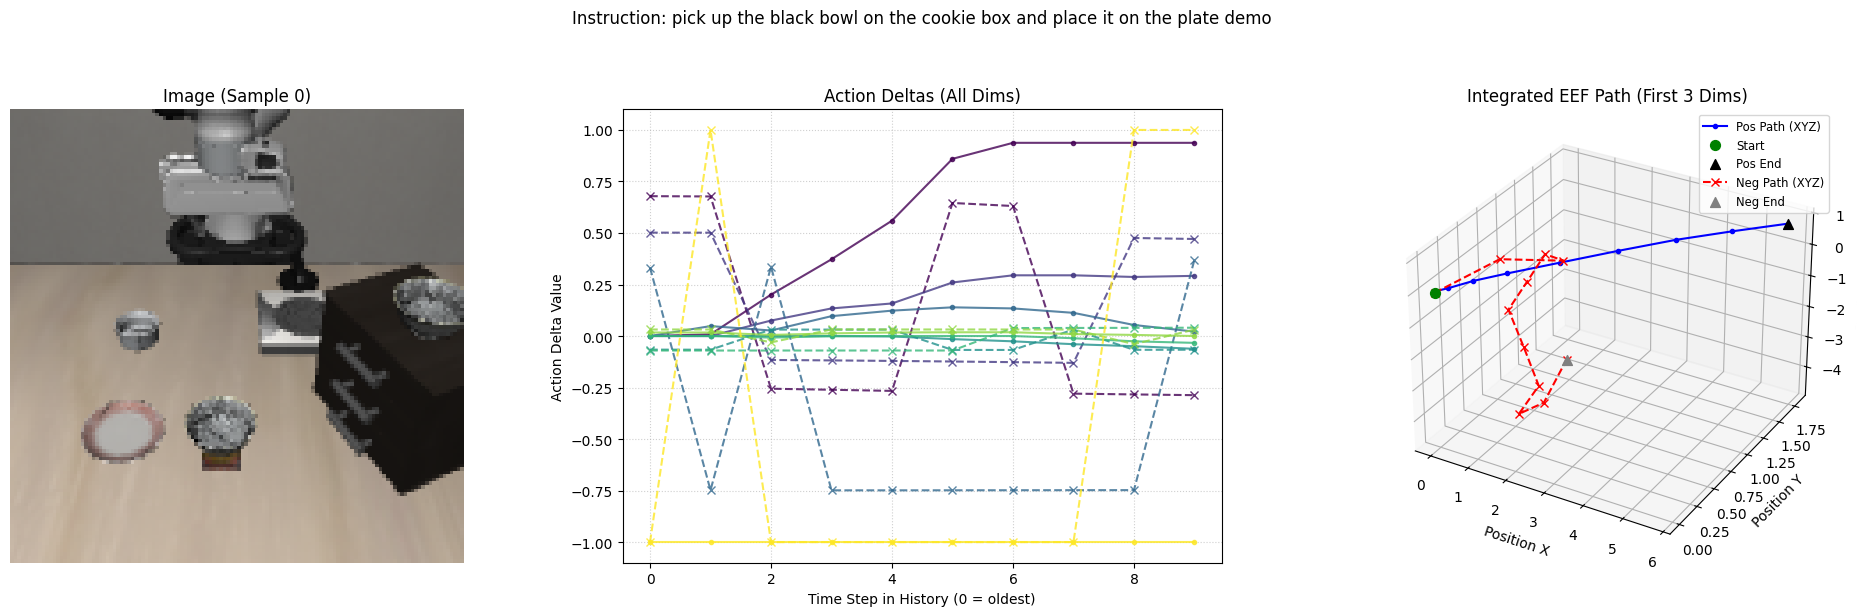

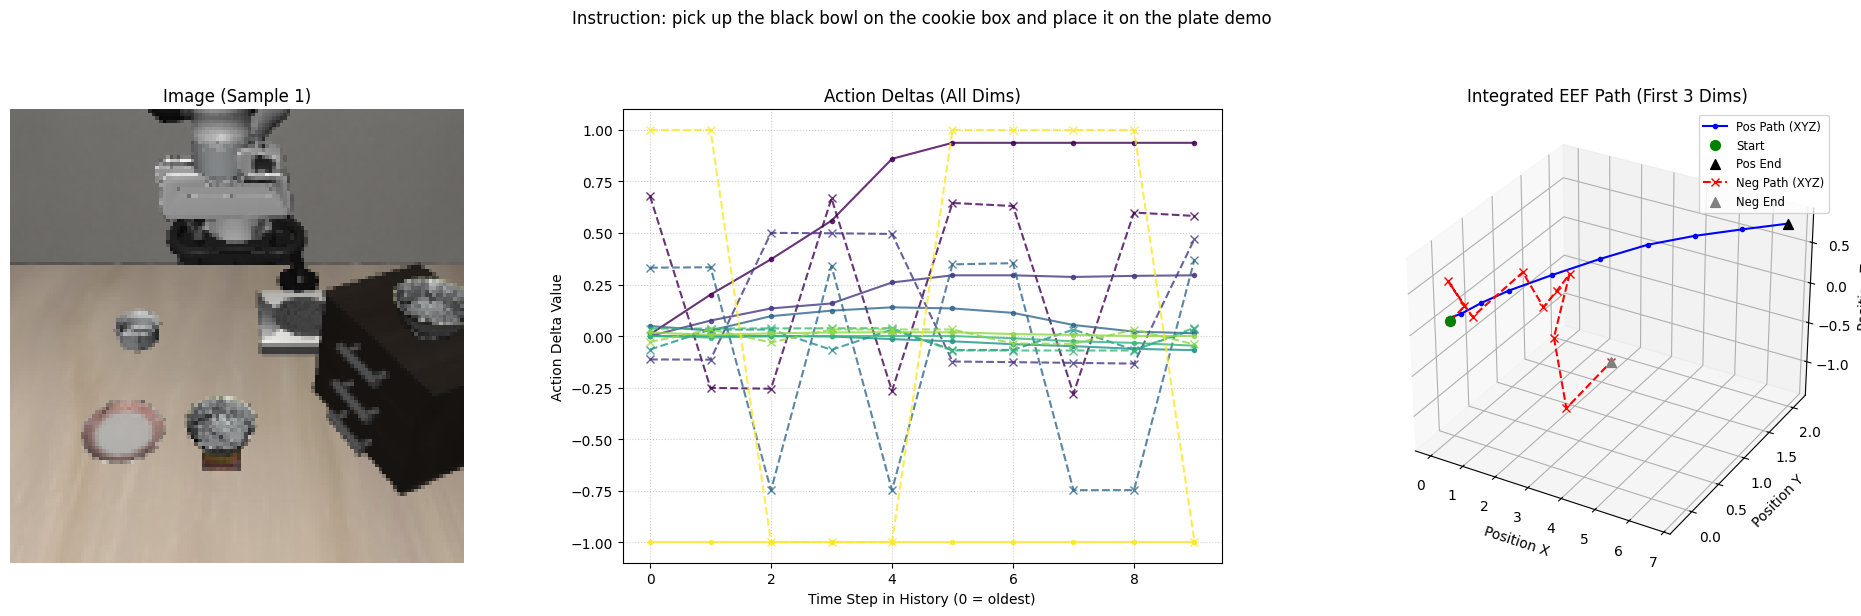

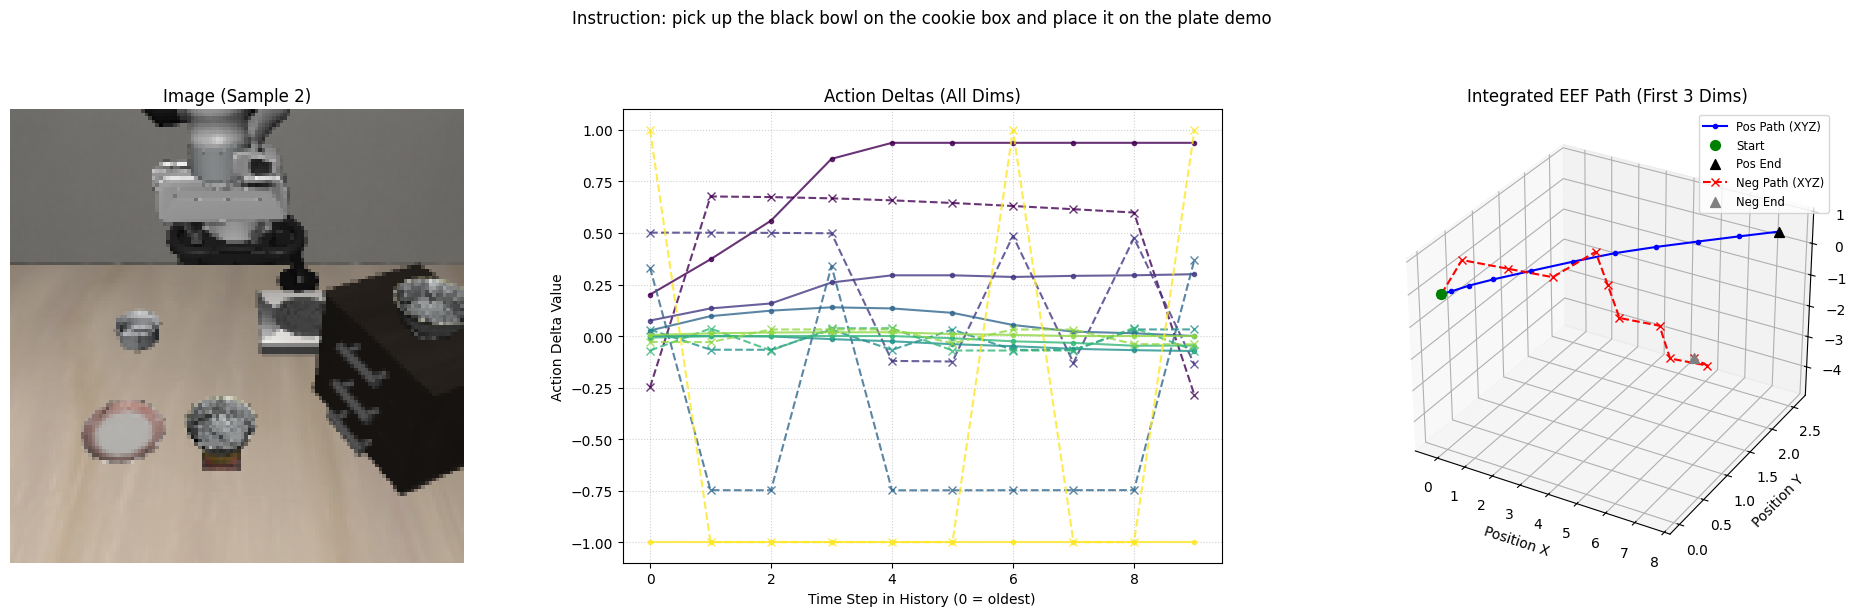


Processing instruction: 'pick up the black bowl next to the plate and place it on the plate demo'
  Found 5513 samples, visualizing the first 3...


Plotting 'pick up the black bowl next to...':   0%|          | 0/3 [00:00<?, ?it/s]

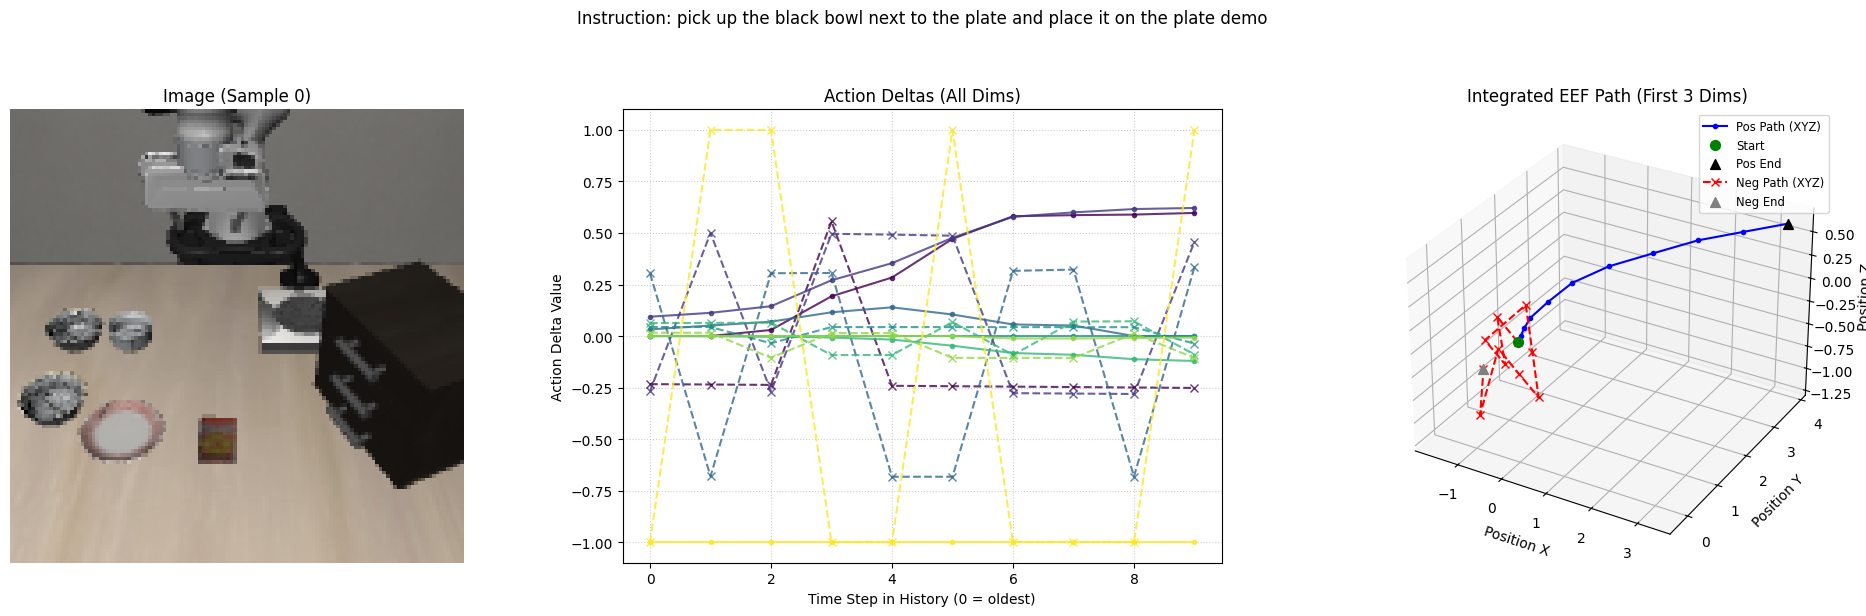

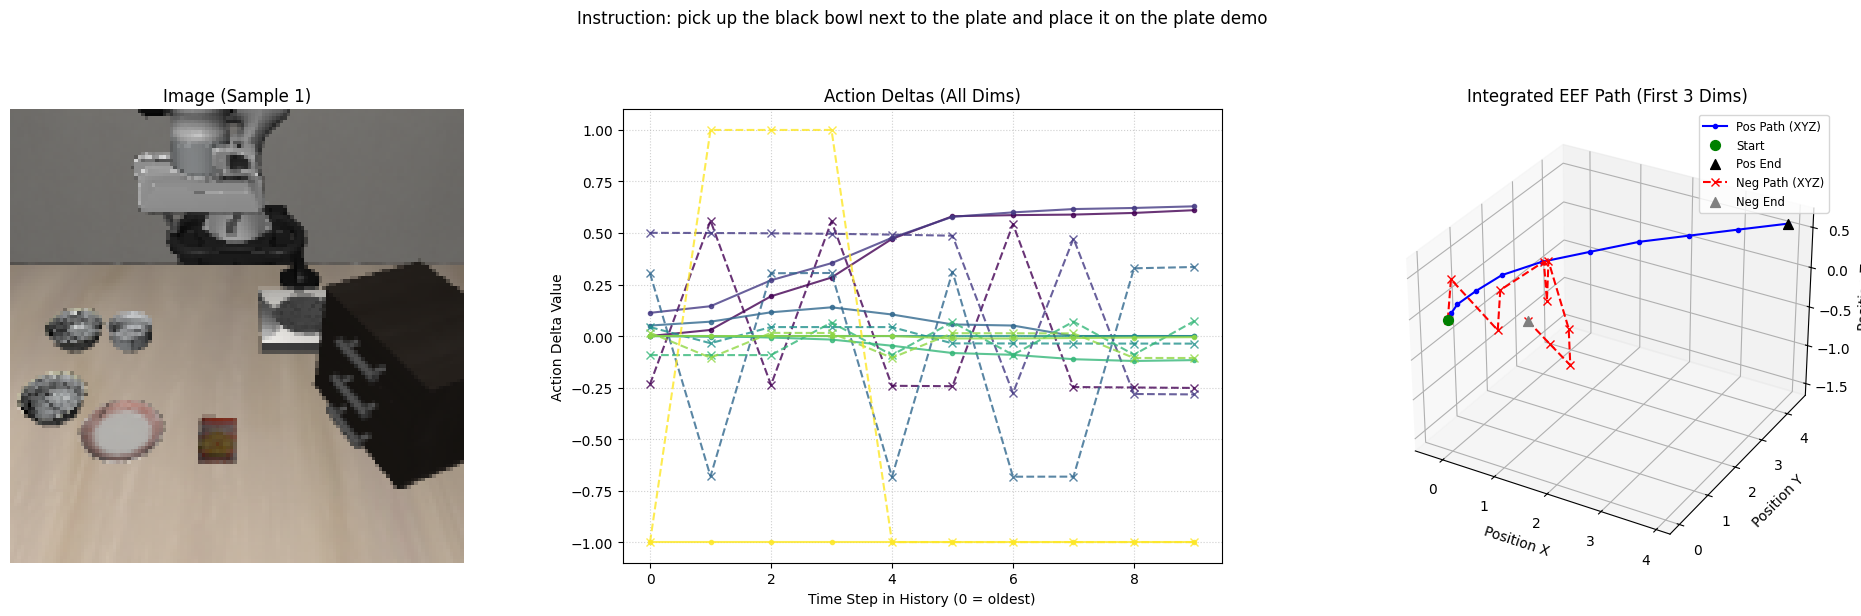

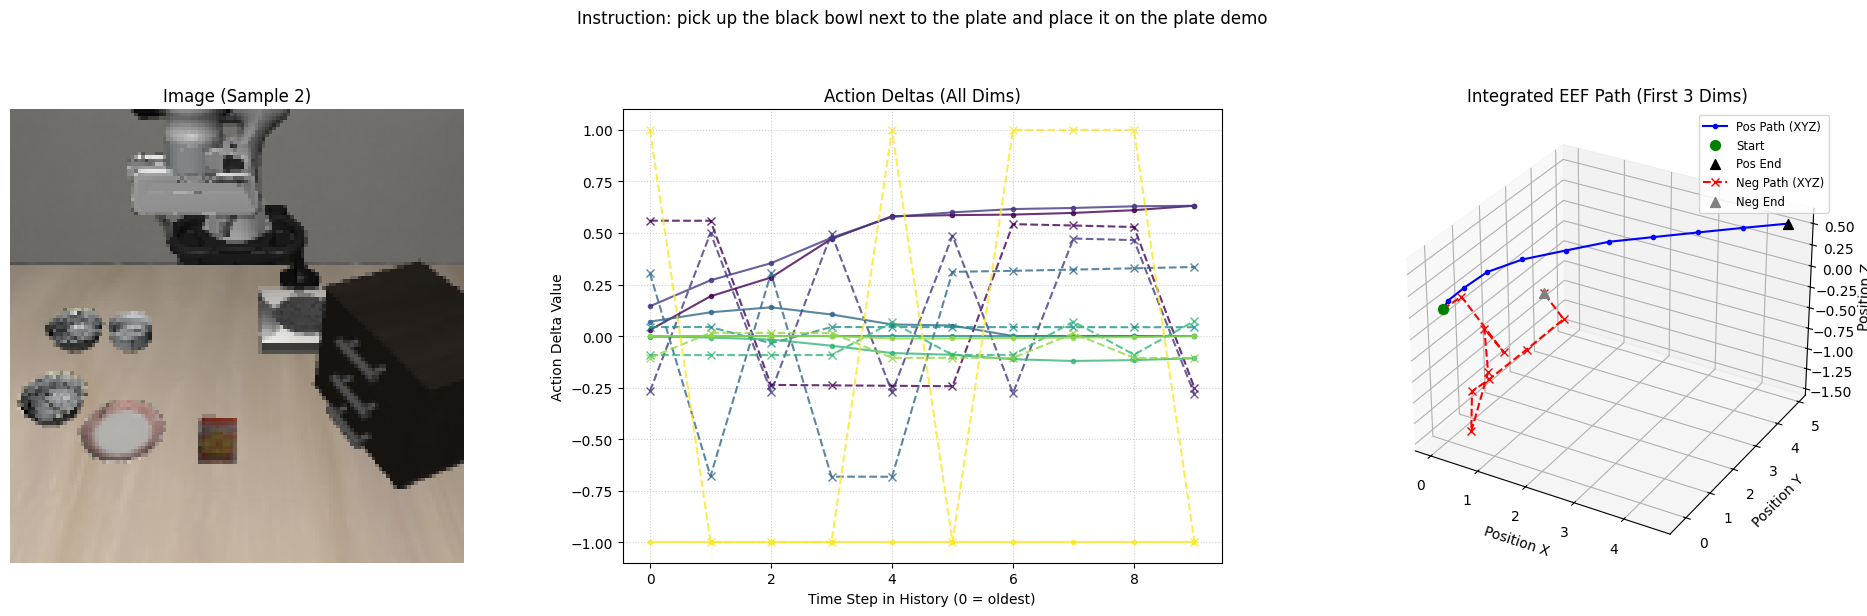


Visualization complete.


In [13]:
# Cell 6: Visualization Logic (Modified to integrate actions for 3D plot)

if augmented_dataset and available_instructions_list: # Check if dataset and list exist
    
    # --- Resolve target instructions from selection ---
    instructions_to_plot = []
    valid_selection = True
    for selection in target_selection:
        if isinstance(selection, int):
            if 0 <= selection < len(available_instructions_list):
                instructions_to_plot.append(available_instructions_list[selection])
            else:
                print(f"Error: Index {selection} is out of range (0-{len(available_instructions_list)-1}).")
                valid_selection = False
        elif isinstance(selection, str):
            if selection in augmented_dataset:
                instructions_to_plot.append(selection)
            else:
                print(f"Error: Instruction string '{selection}' not found in the dataset.")
                valid_selection = False
        else:
            print(f"Error: Invalid selection type '{type(selection)}'. Please use integers or strings.")
            valid_selection = False
            
    if not valid_selection:
        print("\nAborting visualization due to invalid selection.")
    elif not instructions_to_plot:
        print("\nNo valid instructions selected for plotting.")
    else:
        print("\nInstructions selected for plotting:")
        for instr in instructions_to_plot:
            print(f" - {instr}")
        
        # --- Create Output Directory if saving is enabled ---
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            print(f"\nSaving visualizations (if enabled) to: {output_dir}")

        # --- Visualize Selected Samples ---
        for instruction in instructions_to_plot:
            print(f"\nProcessing instruction: '{instruction}'")
            data = augmented_dataset[instruction]
            samples = data.get('samples', [])

            if not samples:
                print(f"  No samples found for this instruction.")
                continue

            samples_to_plot = samples[:num_samples_per_instruction]
            print(f"  Found {len(samples)} samples, visualizing the first {len(samples_to_plot)}...")

            for i, sample_data in enumerate(tqdm(samples_to_plot, desc=f"Plotting '{instruction[:30]}...'")):
                image_np = sample_data.get('image')
                pos_hist_actions = sample_data.get('pos_action_hist') # Action deltas/velocities
                neg_hist_actions = sample_data.get('neg_action_hist') # Action deltas/velocities

                if image_np is None or pos_hist_actions is None or neg_hist_actions is None:
                    print(f"  Skipping sample {i} due to missing data.")
                    continue

                history_length, action_dim = pos_hist_actions.shape
                time_steps = np.arange(history_length)

                # --- Create Plot ---
                fig = plt.figure(figsize=(20, 6)) 
                
                # Subplot 1: Image 
                ax_img = fig.add_subplot(1, 3, 1)
                try:
                    img_pil = Image.fromarray(image_np.astype('uint8'))
                    ax_img.imshow(img_pil)
                    ax_img.set_title(f"Image (Sample {i})")
                    ax_img.axis('off')
                except Exception as img_err:
                    ax_img.set_title(f"Image Error (Sample {i})")
                    print(f"  Error displaying image for sample {i}: {img_err}")

                # Subplot 2: 1D Action (Delta) Trajectories
                ax_traj = fig.add_subplot(1, 3, 2)
                colors = plt.cm.viridis(np.linspace(0, 1, action_dim)) 
                for dim in range(action_dim):
                    ax_traj.plot(time_steps, pos_hist_actions[:, dim], color=colors[dim], linestyle='-', marker='.', alpha=0.8)
                    ax_traj.plot(time_steps, neg_hist_actions[:, dim], color=colors[dim], linestyle='--', marker='x', alpha=0.8)
                ax_traj.set_title(f"Action Deltas (All Dims)") # Clarify title
                ax_traj.set_xlabel("Time Step in History (0 = oldest)")
                ax_traj.set_ylabel("Action Delta Value")
                ax_traj.grid(True, linestyle=':', alpha=0.6)
                
                # Subplot 3: 3D Integrated Trajectory Path (First 3 Dims)
                ax_3d = fig.add_subplot(1, 3, 3, projection='3d')
                if action_dim >= 3:
                    # --- Integrate Actions to get Position Path ---
                    # Start at origin (0,0,0). Path has H+1 points.
                    pos_path = np.zeros((history_length + 1, 3)) 
                    neg_path = np.zeros((history_length + 1, 3)) 
                    
                    for k in range(history_length):
                        pos_path[k+1] = pos_path[k] + pos_hist_actions[k, :3]
                        neg_path[k+1] = neg_path[k] + neg_hist_actions[k, :3]
                    # ---------------------------------------------

                    # Positive Path
                    ax_3d.plot(pos_path[:, 0], pos_path[:, 1], pos_path[:, 2], marker='.', linestyle='-', color='blue', label='Pos Path (XYZ)')
                    ax_3d.scatter(pos_path[0, 0], pos_path[0, 1], pos_path[0, 2], color='green', s=50, label='Start', depthshade=True) # Shared start
                    ax_3d.scatter(pos_path[-1, 0], pos_path[-1, 1], pos_path[-1, 2], color='black', marker='^', s=50, label='Pos End', depthshade=True)

                    # Negative Path
                    ax_3d.plot(neg_path[:, 0], neg_path[:, 1], neg_path[:, 2], marker='x', linestyle='--', color='red', label='Neg Path (XYZ)')
                    ax_3d.scatter(neg_path[-1, 0], neg_path[-1, 1], neg_path[-1, 2], color='grey', marker='^', s=50, label='Neg End', depthshade=True)

                    ax_3d.set_xlabel('Position X') # Update labels
                    ax_3d.set_ylabel('Position Y')
                    ax_3d.set_zlabel('Position Z')
                    ax_3d.set_title('Integrated EEF Path (First 3 Dims)')
                    ax_3d.legend(fontsize='small')
                else:
                    ax_3d.text(0.5, 0.5, 0.5, "Action dim < 3", ha='center', va='center')
                    ax_3d.set_title('EEF Path (N/A)')
                    ax_3d.axis('off')

                plt.suptitle(f"Instruction: {instruction}", y=1.02) 
                plt.tight_layout(rect=[0, 0, 1, 0.97]) 

                if output_dir:
                    safe_instruction = "".join([c if c.isalnum() else "_" for c in instruction])[:50]
                    save_path = os.path.join(output_dir, f"{safe_instruction}_sample_{i}_path_3d.png") # Added suffix
                    try:
                        plt.savefig(save_path, bbox_inches='tight') 
                    except Exception as save_err:
                        print(f"  Error saving plot for sample {i}: {save_err}")
                
                plt.show() 
                plt.close(fig) 
        
        print("\nVisualization complete.")

elif not augmented_dataset:
    print("Dataset could not be loaded. Cannot proceed.")
else: 
     print("Dataset loaded, but no instructions found.")